_Version log: trying to use the dct insted of the fft._

In [23]:
from sklearn.linear_model import Lasso #Literal magic
import dask.array as dk
import sparse
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as spimg
from scipy import optimize as spopt, fft as spfft
from PIL import Image #I prefer Pillow to imageio


For the compressed sensing, I am minimising,
$\mathcal{F} (A)$,
while meeting the condition,
\begin{equation}
    C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (A) - B = 0,
\end{equation}
where $A$ is the signal that needs to be solved for, $B$ is the sparce signal and $C$ is cropping transformation matrix such that,
\begin{equation}
    C \times A = B.
\end{equation}
$\mathcal{F}( )$ and $I$ are the FFT function and identerty matrix respectively.

C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\dask\array\core.py:1712: FutureWarning: The `numpy.sort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


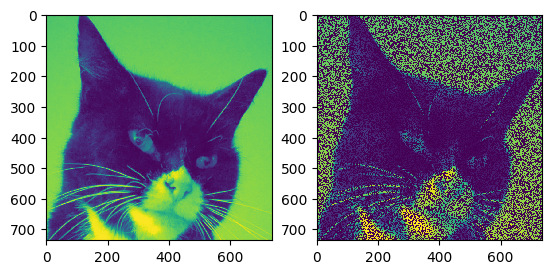

In [24]:
compression = 1 #fraction of the image to keep (The image is too large to process quickly)

# original image
img = Image.open('alfie.png') # read image
img = dk.array(img).sum(axis=2) # make image grayscale
target = spimg.zoom(img, compression) # scipy ndimage.zoom compresses (or interpolates) an image.
total_points = dk.multiply(*target.shape)
target_flat = target.flatten()

# image subsample
subsample = 0.5 #fraction of the image to subsample
random_points = dk.random.choice(total_points, round(total_points *subsample), replace= False)
random_points = np.sort(random_points) #Not nessisary but makes it easier to look at.
signal_flat = dk.zeros(total_points)
signal_flat[random_points] = target_flat[random_points] #dask doesn't like being used as an index
signal_sparce = target_flat[random_points]
signal = dk.reshape(signal_flat, target.shape)

fig, axs = plt.subplots(1,2)

axs[0].imshow(target, interpolation= "nearest")
axs[1].imshow(signal, interpolation= "nearest")

plt.show()

In [25]:
target.shape

(736, 736)

In [26]:
cropping_matrix = sparse.eye(total_points, dtype= np.float16)
cropping_matrix = cropping_matrix[random_points] #cropping matrix operator

null_vector = dk.zeros(total_points)


dct_matrix = dk.array(spfft.idct(cropping_matrix[0].todense()))
for cropping_matrix_row in cropping_matrix[1:]:
    dct_matrix_row = spfft.idct(cropping_matrix_row.todense())
    dk.vstack((dct_matrix, dct_matrix_row))

MemoryError: 

In [ ]:
cropping_matrix = sparse.eye(total_points, dtype= np.float16)
cropping_matrix = cropping_matrix[random_points] #cropping matrix operator

null_vector = dk.zeros(total_points)

for cropping_matrix_row in cropping_matrix:
    print(np.argmax(cropping_matrix_row) ,end= " ")


dct_matrix = spfft.idct(sparse.eye(total_points), axis= 0)
measurement_matrix = dk.matmul(cropping_matrix, dct_matrix)

fig, axs = plt.subplots(2,1)

axs[0].imshow(cropping_matrix, interpolation= "nearest")
axs[1].imshow(measurement_matrix, interpolation= "nearest")

plt.show()

NameError: name 'sparse' is not defined

In [ ]:
null_vector = dk.zeros(total_points)

In [ ]:
########WARNING VERY SLOW!!!############

regularization_strength = 1e-4

# Create a Lasso model
lasso = Lasso(alpha=regularization_strength)  # Adjust the alpha parameter for L1 regularization strength

# Fit the model to your data
lasso.fit(measurement_matrix, signal_sparce)  # X is your measurement matrix, y is the observed signal

# Get the estimated sparse signal
result_FFT = lasso.coef_

print(result_FFT.shape)
print(total_points)

(5476,)
5476


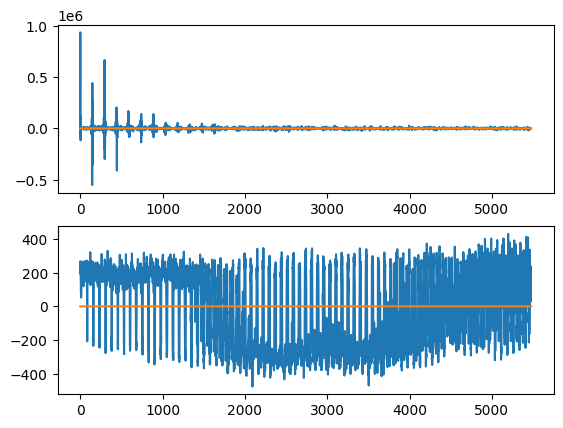

In [ ]:
result_flat = spfft.idct(result_FFT)

fig, axs = plt.subplots(2,1)

axs[0].plot(dk.real(result_FFT))
axs[0].plot(dk.imag(result_FFT))
axs[1].plot(dk.real(result_flat))
axs[1].plot(dk.imag(result_flat))

plt.show()

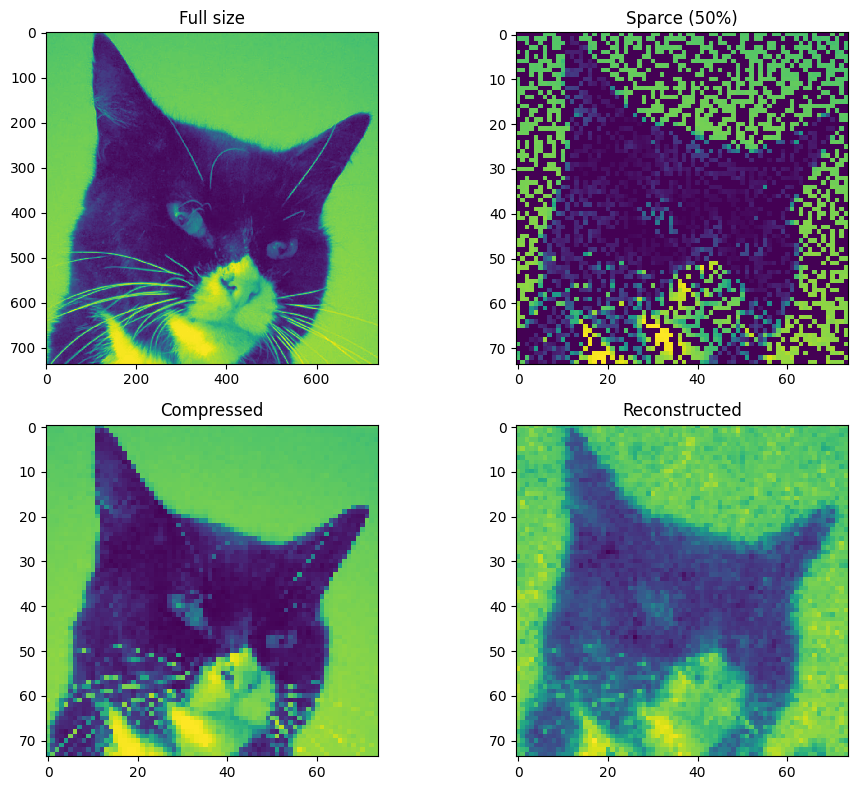

In [ ]:
result = dk.reshape(result_flat, target.shape)

fig, axs = plt.subplots(2,2, figsize= (10,8))
axs[0][0].imshow(img, interpolation = "nearest")
axs[0][0].set_title("Full size")
axs[1][0].imshow(target, interpolation = "nearest")
axs[1][0].set_title("Compressed")
axs[0][1].imshow(signal, interpolation = "nearest")
axs[0][1].set_title("Sparce (50%)")
axs[1][1].imshow(result, interpolation = "nearest")
axs[1][1].set_title("Reconstructed")

plt.tight_layout()
plt.show()